In [1]:
import warnings
warnings.filterwarnings("ignore")

import inspect
from typing import List, Optional, Union
import random

import numpy as np
import torch as th
import torchvision
import torchvision.transforms as T

from PIL import Image
import gradio as gr
from diffusers import StableDiffusionInpaintPipeline
from rembg.rembg import remove
from Tools.upscaler import Upscaler
from Tools.helpers import *
upscaler = Upscaler()

device = th.device('cuda' if th.cuda.is_available() else 'cpu')

In [2]:
model_path = "./stable-diffusion-inpainting"
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    revision="fp16", 
    torch_dtype=th.float16,
).to(device)

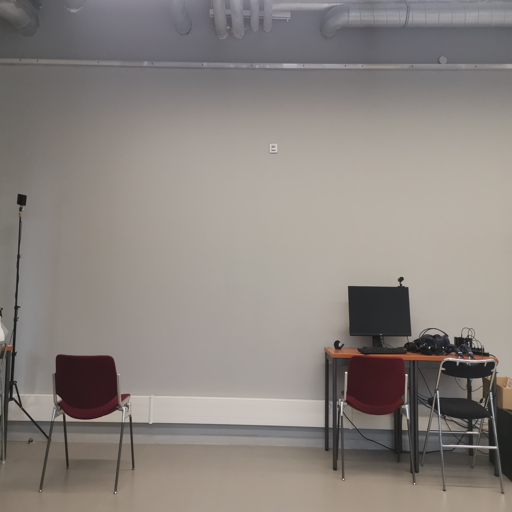

In [3]:
image = Image.open("input_images/0.png").resize((512, 512))
image

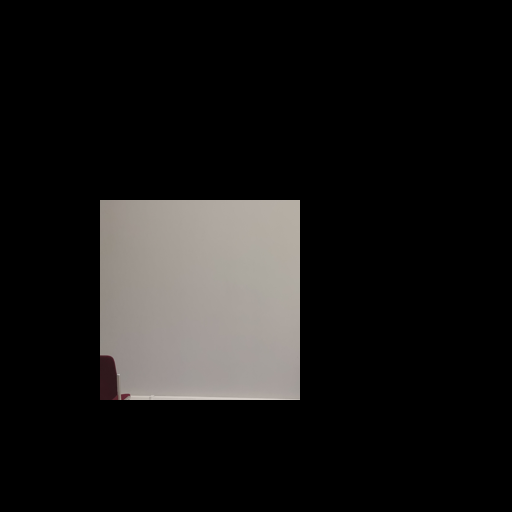

In [4]:
to_image = T.ToPILImage()
to_tensor = T.PILToTensor()

posX, posY = 200, 300
size = 200

x1, x2 = int(posX-(size/2)), int(posX+(size/2))
y1, y2 = int(posY-(size/2)), int(posY+(size/2))
source_mask_512 = th.zeros(size=(512,512))
source_mask_512[y1:y2, x1:x2] = 1
source_mask_512.size()
source_mask_512 = source_mask_512 * to_tensor(image)*255
mask_image = to_image(source_mask_512)
mask_image 

In [7]:
prompt = "a window towards the mountains"

guidance_scale=7.5
num_samples = 1
seed = random.randint(0, 1000000)
generator = th.Generator(device=device).manual_seed(seed) # change the seed to get different results

images = pipe(
    prompt=prompt,
    image=image,
    mask_image=mask_image,
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

100%|██████████| 50/50 [00:11<00:00,  4.34it/s]


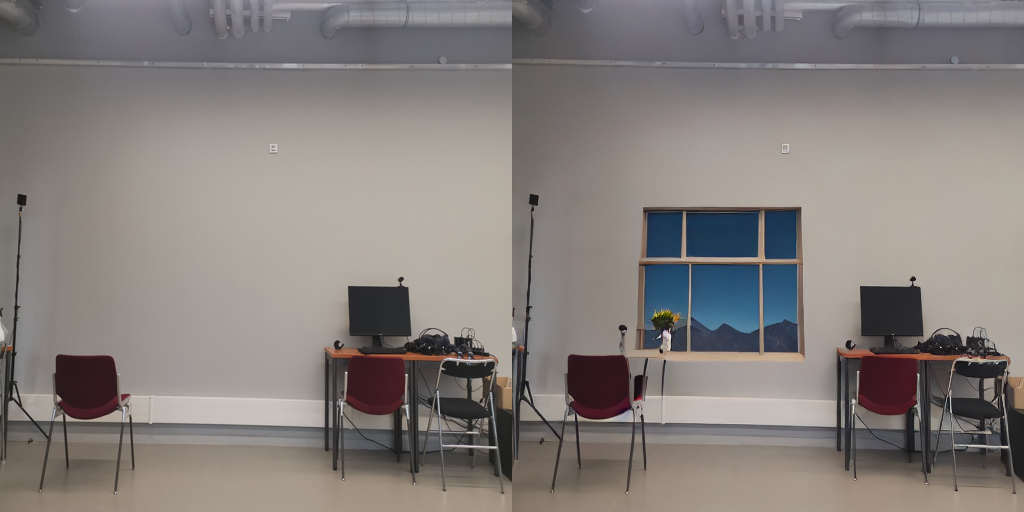

In [8]:
list_images = images.copy()
list_images.insert(0, image)
image_grid(list_images, 1, len(list_images))

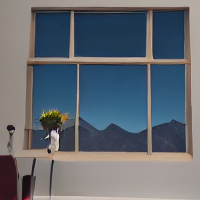

In [10]:
generated_parts = [to_image(to_tensor(img)[:, y1:y2, x1:x2]) for img in images]
generated_part = generated_parts[-1]
generated_part

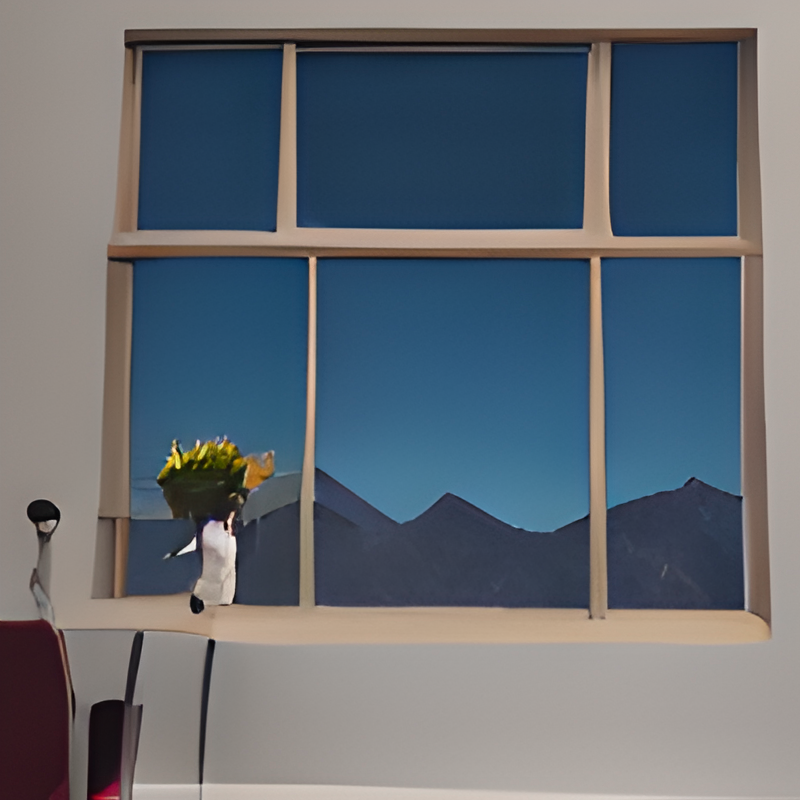

In [11]:
upscaled_part = upscaler.upscale(generated_part)
upscaled_part

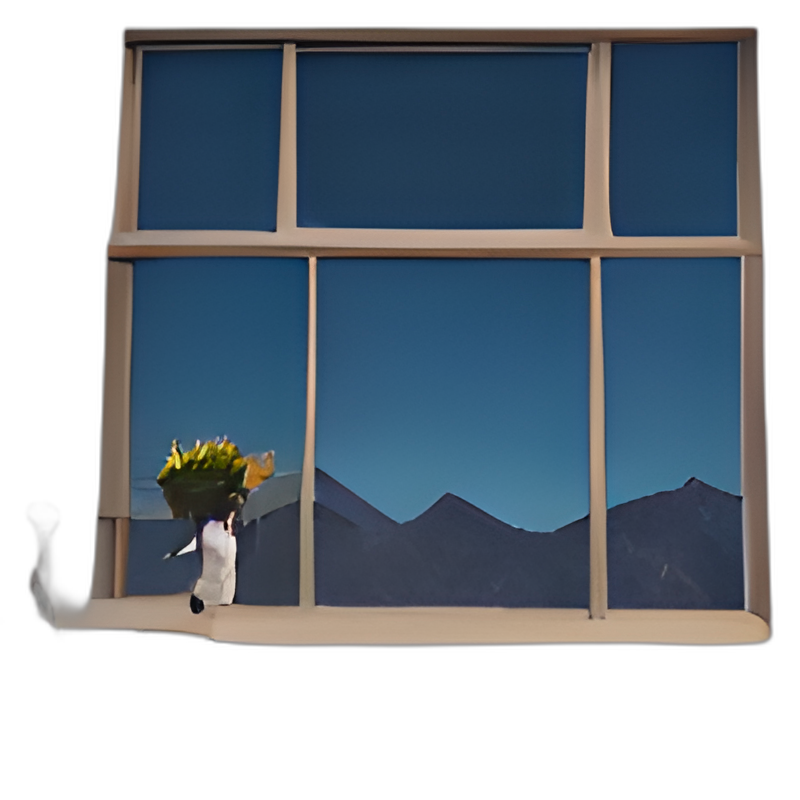

In [12]:
extracted_part = remove(upscaled_part)
extracted_part